In [1]:
!pip install -q shap xgboost scipy pandas matplotlib seaborn

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np
from scipy import stats
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

import xgboost
import shap

np.random.seed(42)

## Utilities

In [3]:
from fastcore.basics import patch_to

@patch_to(pd.DataFrame)
def display(self): 
    display(HTML(self.to_html()))

def logical_and(*args):
    if len(args) == 1:
        return args[0]
    return np.logical_and(*args)

def groupby(iterable, key_func, val_func=None):
    res = dict()
    for elem in iterable:
        key = key_func(elem)
        value = val_func(elem) if val_func else elem
        grp = res.get(key, [])
        grp.append(value)
        res[key] = grp
    return res

In [379]:
# TARGETS = ['OverallQual']
# UNUSED = ['SalePrice', 'YrSold', 'MoSold', 'SaleCondition']
TARGETS = ['SalePrice']
UNUSED = ['YrSold']

## Data cleaning

In [380]:
ORDINALS_INFO = [
    ('BsmtExposure',['NA', 'No', 'Mn', 'Av', 'Gd']),
    ('BsmtQual',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('BsmtCond', ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('ExterQual',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('ExterCond', ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('FireplaceQu',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageCond',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageQual',['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('HeatingQC',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('KitchenQual',['NA','Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('LandSlope',['Gtl', 'Mod', 'Sev']),
    ('PoolQC', ['NA', 'Fa', 'TA', 'Gd', 'Ex']),
    ('OverallQual', list(range(1, 11))),
    ('OverallCond', list(range(1, 11))),
    ('MoSold', list(range(1,13))),
    ('YrSold', None),
    ('YearBuilt', None),
    ('YearRemodAdd', None),
    ('GarageYrBlt', None),
]
ORDINALS = [feat for feat, _ in ORDINALS_INFO]

NOMINALS = [
    'Alley',
    'BldgType',
    'BsmtFinType1',
    'BsmtFinType2',
    'CentralAir',
    'Condition1',
    'Condition2',
    'Electrical',
    'Exterior1st',
    'Exterior2nd',
    'Fence',
    'Foundation',
    'Functional',
    'GarageFinish',
    'GarageType',
    'Heating',
    'HouseStyle',
    'LandContour',
    'LotConfig',
    'LotShape',
    'MSSubClass',
    'MSZoning',
    'MasVnrType',
    'MiscFeature',
    'Neighborhood',
    'PavedDrive',
    'RoofMatl',
    'RoofStyle',
    'SaleCondition',
    'SaleType',
    'Street',
    'Utilities'
]

NUMERICALS = [
    '1stFlrSF',
    '2ndFlrSF',
    '3SsnPorch',
    'BedroomAbvGr',
    'BsmtUnfSF',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtFullBath',
    'BsmtHalfBath',
    'EnclosedPorch',
    'Fireplaces',
    'FullBath',
    'GarageArea',
    'GarageCars',
    'GrLivArea',
    'HalfBath',
    'KitchenAbvGr',
    'LotArea',
    'LotFrontage',
    'LowQualFinSF',
    'MasVnrArea',
    'MiscVal',
    'OpenPorchSF',
    'PoolArea',
    'ScreenPorch',
    'TotRmsAbvGrd',
    'TotalBsmtSF',
    'WoodDeckSF',
    'SalePrice'
]


VAR_TYPE_MAP = {
    col: t 
    for t, cols in [('numerical', NUMERICALS), ('ordinal', ORDINALS), ('nominal', NOMINALS)] 
    for col in cols
}

def find_inconsistencies(dataf):
    logical_checks = dict([
        ('YearBuilt', lambda dataf: dataf['YearBuilt'] < 1500),
        ('YearRemodAdd', lambda dataf: dataf['YearRemodAdd'] < 1500),
        ('GarageYrBlt', lambda dataf: dataf['GarageYrBlt'] < 1500),
        ('YrSold', lambda dataf: (
            (dataf['YrSold'] < 2000) \
            | (~dataf['YearBuilt'].isna() & ~dataf['YrSold'].isna() & (dataf['YrSold'] < dataf['YearBuilt']))
        )),
    ])

    for col, category_values in ORDINALS_INFO: 
        if col not in dataf.columns:
            continue
        if category_values is None:
            continue
        mask = (~dataf[col].isna() & ~dataf[col].isin(category_values))
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)

    for col, predicate in logical_checks.items(): 
        if col not in dataf.columns:
            continue
        mask = (~dataf[col].isna() & predicate(dataf))
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)
    
    for col in NUMERICALS:
        if col not in dataf.columns:
            continue
        mask = (~dataf[col].isna() & (dataf[col] < 0))
        n_inconsistent = mask.sum()
        if n_inconsistent == 0:
            continue
        yield (col, mask)
    
def erase_inconsistencies(dataf):
    dataf = dataf.copy()
    col_inconsistencies = {
        col: logical_and(*[mask.values for mask in masks]) 
        for col, masks in groupby(find_inconsistencies(dataf), key_func = lambda t: t[0], val_func = lambda t: t[1]).items()
    }
    for col, mask in col_inconsistencies.items():
        n_inconsistent = mask.sum()
        print(f"{n_inconsistent} inconsistent values found in {col}")
        dataf[mask].display()
        dataf.loc[mask, col] = np.nan
    
    return dataf

def drop_rows_missing_target(dataf, targets):
    if not np.all([col in dataf.columns for col in targets]):
        return dataf
    size = len(dataf)
    dataf = dataf.dropna(axis=0, how='any', subset=targets)
    new_size = len(dataf)
    n_dropped = size - new_size
    if n_dropped > 0:
        print(f'Dropped {n_dropped} rows missing target variables')
    return dataf

def fill_missing_values_by_data_description(dataf):
    dataf = dataf.copy()
    for col in ORDINALS + NOMINALS:
        if col not in dataf.columns:
            continue
        val = 'NA' if col != 'MasVnrType' else 'None'
        dataf[col] = dataf[col].fillna(val)
    return dataf

def prepare_dataset(dataf):
    dataf = (dataf
        .drop(columns=UNUSED, errors='ignore')
        .pipe(drop_rows_missing_target, targets=TARGETS)
        .pipe(erase_inconsistencies)
        .pipe(fill_missing_values_by_data_description)
    )

    for col in NUMERICALS:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype('float')
    
    for col, categories in ORDINALS_INFO:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype(CategoricalDtype(categories=categories, ordered=True))
    
    for col in NOMINALS:
        if col not in dataf.columns:
            continue
        dataf[col] = dataf[col].astype('category')
    
    existing_cols = set(dataf.columns)
    col_order =  [col for col in NUMERICALS + ORDINALS + NOMINALS if col in existing_cols]
    return dataf[col_order]

## Training

In [381]:
def get_numerical_cols(dataf):
    return dataf.select_dtypes('number').columns.tolist()

def get_ordinal_cols(dataf):
    return [col for col in dataf.select_dtypes('category').columns if dataf[col].dtypes.ordered]

def get_nominal_cols(dataf):
    return [col for col in dataf.select_dtypes('category').columns if not dataf[col].dtypes.ordered]

In [382]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA

def make_preprocessor(x_train: pd.DataFrame):
    numerical_cols = get_numerical_cols(x_train)

    skewness = x_train[numerical_cols].skew()
    sym_numerical_cols = sorted(skewness[skewness.abs() <= 0.5].index.tolist())
    sym_transformer  = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
    ])

    skw_numerical_cols = sorted(list(set(numerical_cols).difference(sym_numerical_cols)))
    skw_transformer  = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', MinMaxScaler()),
    ])

    ordinal_cols = sorted(get_ordinal_cols(x_train))
    ordinal_category_list = [dt.categories.tolist() for dt in x_train[ordinal_cols].dtypes]
    ordinal_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=ordinal_category_list)),
    ])

    nominal_cols = sorted(get_nominal_cols(x_train))
    nominal_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
    ])

    preprocessor = ColumnTransformer(
        [
            ('numerical_sym', sym_transformer, sym_numerical_cols),
            ('numerical_skw', skw_transformer, skw_numerical_cols),
            ('ordinal', ordinal_transformer, ordinal_cols),
            ('nominal', nominal_transformer, nominal_cols),
        ],
        remainder='drop'
    )
    preprocessor.fit(x_train)

    nominal_enc_cols = preprocessor.transformers_[3][1].named_steps['encoder'].get_feature_names_out(nominal_cols).tolist()
    preprocessor.feature_names_out_ = sym_numerical_cols + skw_numerical_cols + ordinal_cols + nominal_enc_cols
    
    return preprocessor 

In [383]:
from sklearn.model_selection import train_test_split

data_dir = Path('.')

df = pd.read_csv(data_dir / 'train.csv', low_memory=False, index_col='Id')
test_df = pd.read_csv(data_dir / 'test.csv', low_memory=False, index_col='Id')

df = prepare_dataset(df)
x_train, x_val, y_train, y_val = train_test_split(df.drop(columns=TARGETS), df[TARGETS], test_size=0.2, random_state=7)
x_test = prepare_dataset(test_df)


In [384]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, r2_score

def make_searcher(estimator, param_grid, cv=5, score_averaging = 'weighted', seed=42):
    return GridSearchCV(
        estimator = estimator, 
        param_grid = param_grid,
        scoring = {
            'r2': make_scorer(r2_score), 
        }, 
        refit = 'r2',
        cv = cv, # number of folds for cross validation
        verbose=0, 
        n_jobs = -1
    )

In [385]:
import json

def fmt_search_results(search):
    sdf = pd.DataFrame(search.cv_results_)
    cols2keep = [col for col in sdf.columns if col=='params' or col.startswith('split')]
    sdf = sdf[cols2keep]
    sdf.columns = pd.MultiIndex.from_tuples([(np.nan, col) if col=='params' else (col[:6], col[12:]) for col in sdf.columns])
    sdf = (sdf.stack(0)
       .ffill()
       .reset_index()
       .drop(columns=['level_0'])
       .dropna(how='any', axis=0)
       .rename(columns={"level_1": "split"})
      )
    
    sdf['estimator_name'] = search.estimator.steps[-1][-1].__class__.__name__
    sdf['best_estimator'] = search.best_estimator_
    return sdf[['estimator_name', 'params', 'split', 'r2', 'best_estimator']]

def average_over_splits(sdf):
    return (sdf
        .assign(params=lambda x: x['params'].apply(str))
        .groupby(['estimator_name', 'params'])
        .agg({
            'r2': np.mean,
            'best_estimator': lambda g: next(iter(g)),
        })
        .sort_values(by='r2', ascending=False)
        .reset_index()
    )

In [386]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

model_param_grids = [
    (
        RandomForestRegressor(), 
        dict(
            # preprocessor__numerical__pca__n_components=[3,5,7],
            # preprocessor__categorical__feat_selection__k=[10, 20, 30],
            # model__min_samples_leaf = [1, 3, 5],
            model__n_estimators = [100, 64, 32],
            model__max_depth= [3, 6, 10],
            model__min_samples_split = [2, 4, 8],
            model__max_features=['auto'],
        )
    ),
    (
        XGBRegressor(), 
        dict(
            # model__n_estimators = [100, 64, 32],
            # model__max_depth= [3, 6, 10],
        )
    ),
]

search_result_df = average_over_splits(pd.concat([
    fmt_search_results(
        make_searcher(Pipeline([('preprocessor', make_preprocessor(x_train)), ('model', model)]), pg)
            .fit(x_train, y_train.values.ravel())
    ) 
    for (model, pg) in model_param_grids
]))

In [387]:
search_result_df[['estimator_name',	'params', 'r2']].display()

,estimator_name,params,r2
0,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 100}",0.823031
1,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 8, 'model__n_estimators': 64}",0.820476
2,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 4, 'model__n_estimators': 100}",0.820299
3,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 4, 'model__n_estimators': 64}",0.819906
4,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 8, 'model__n_estimators': 100}",0.818319
5,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'auto', 'model__min_samples_split': 2, 'model__n_estimators': 32}",0.816129
6,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'auto', 'model__min_samples_split': 2, 'model__n_estimators': 100}",0.815056
7,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 8, 'model__n_estimators': 32}",0.814269
8,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 64}",0.814215
9,RandomForestRegressor,"{'model__max_depth': 10, 'model__max_features': 'auto', 'model__min_samples_split': 4, 'model__n_estimators': 100}",0.813996


In [388]:
best_estimator = search_result_df.reset_index().loc[0, 'best_estimator']

print('='*32)
print('R2 score')
print('='*32)
print(f"train      set: {best_estimator.score(x_train, y_train.values.ravel()):.3f}")
print(f"validation set: {best_estimator.score(x_val, y_val.values.ravel()):.3f}")
print('='*32)

R2 score
train      set: 0.961
validation set: 0.849


## Model interpretation

In [389]:
pp = make_preprocessor(x_train)
process = lambda x: pd.DataFrame(pp.transform(x), columns=pp.feature_names_out_)
x_train_proc = process(x_train)
x_val_proc = process(x_val)

model = best_estimator.named_steps['model']
# model = xgboost.XGBRegressor().fit(x_train_proc, y_train.values.ravel())
y_train_pred = model.predict(x_train_proc.values)
y_val_pred = model.predict(x_val_proc.values)

In [390]:
# explainer = shap.Explainer(model, output_names=TARGETS)
# shap_values = explainer(x_train_proc)

explainer = shap.TreeExplainer(model, feature_names=pp.feature_names_out_, output_names=TARGETS)
shap_values = explainer(x_train_proc)
shap_values.base_values = shap_values.base_values.ravel()[0]

Prediction: 249855.66


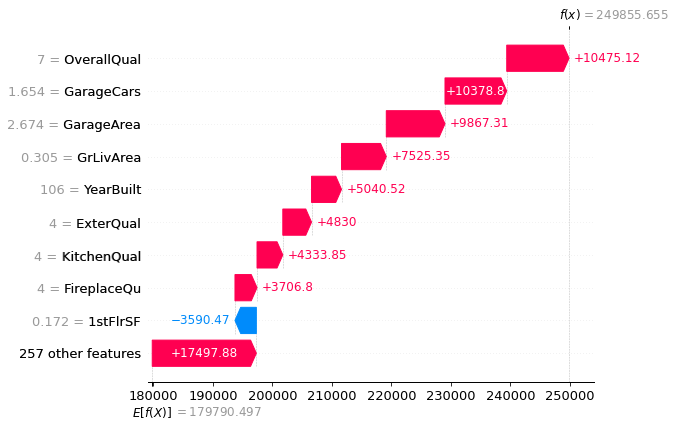

In [391]:
idx = 0
print(f'Prediction: {y_train_pred[idx]:.2f}')
shap.plots.waterfall(shap_values[idx])

Prediction: 134631.53


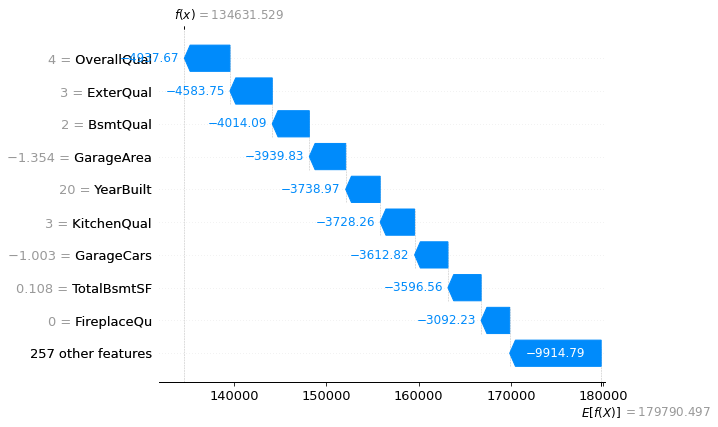

In [392]:
idx = 1
print(f'Prediction: {y_train_pred[idx]:.2f}')
plt.figure(figsize=(16, 12))
shap.plots.waterfall(shap_values[idx])

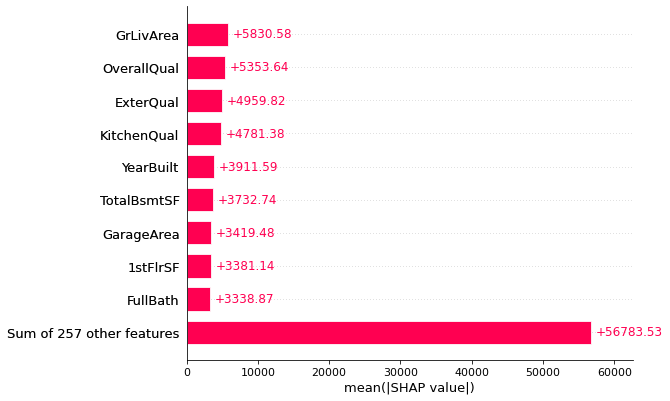

In [397]:
shap.plots.bar(shap_values)

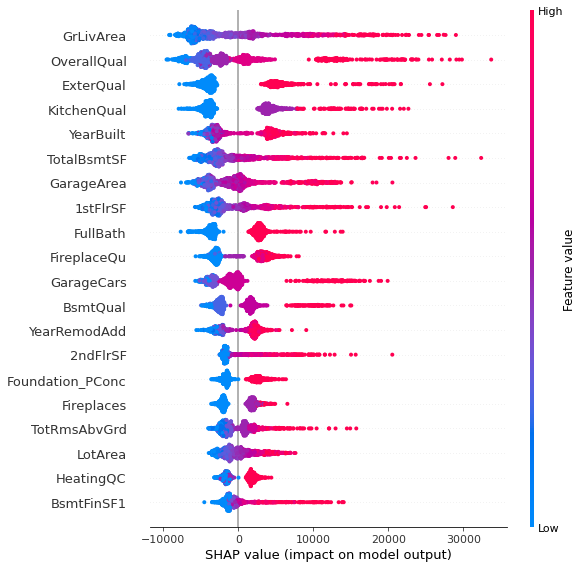

In [398]:
shap.summary_plot(shap_values, x_train_proc)


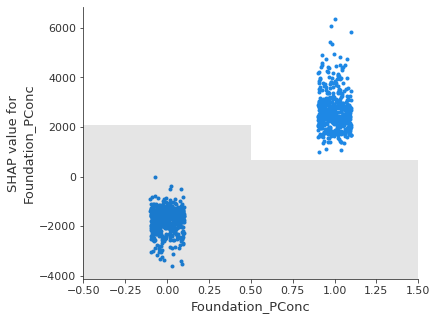

In [405]:
col2idx = {col: idx for idx, col in enumerate(pp.feature_names_out_)}
shap.plots.scatter(shap_values[:, col2idx['Foundation_PConc']])

<BarContainer object of 266 artists>

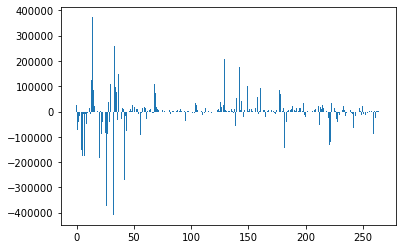

In [400]:
plt.bar(range(shap_values.values.shape[1]), shap_values.values.sum(axis=0))

In [403]:
feature_importances = np.mean(np.abs(shap_values.values), axis=0)
feature_importances = feature_importances / feature_importances.sum()
feature_importance_order = sorted(zip(feature_importances.tolist(), pp.feature_names_out_), reverse=True)
print('\n'.join([f"{col:16}: {imp:.2f}" for imp, col in feature_importance_order[:20]]))

GrLivArea       : 0.06
OverallQual     : 0.06
ExterQual       : 0.05
KitchenQual     : 0.05
YearBuilt       : 0.04
TotalBsmtSF     : 0.04
GarageArea      : 0.04
1stFlrSF        : 0.04
FullBath        : 0.03
FireplaceQu     : 0.03
GarageCars      : 0.03
BsmtQual        : 0.03
YearRemodAdd    : 0.03
2ndFlrSF        : 0.02
Foundation_PConc: 0.02
Fireplaces      : 0.02
TotRmsAbvGrd    : 0.02
LotArea         : 0.02
HeatingQC       : 0.02
BsmtFinSF1      : 0.02


## Backup

In [ ]:
from sklearn.utils.validation import check_is_fitted

pp = make_preprocessor(x_train)
check_is_fitted(pp.transformers_[3][1])
pp.transformers[3][1]

In [ ]:
pp = make_preprocessor(x_train)
process = lambda x: pd.DataFrame(pp.transform(x), columns=pp.feature_names_out_)
x_train_proc = process(x_train)
x_val_proc = process(x_val)

model = xgboost.XGBRegressor().fit(x_train_proc, y_train.values.ravel())

print(model.score(x_train_proc, y_train.values.ravel()))
print(model.score(x_val_proc, y_val.values.ravel()))

y_train_pred = model.predict(x_train_proc)